In [18]:
# The code was removed by Watson Studio for sharing.

#                             New Korean Restaurant in New York City

## Introduction

New York City has something for every taste and attracts a huge amount of tourists to visit each year. From incredible art galleries and museums to some of the world’s best restaurants, New York’s many offerings are well known to most visitors. 

JJ International is a South Korean conglomerate holding company headquartered in Seoul. It comprises numerous businesses in various industries of food and food service, pharmaceutics and biotechnology, entertainment and media. The company wants to explore an possibility to open an authentic Korean Restaurant in Manhattan, NY.


## Data

1. list of neighborhoods in New York City
2. location data from geocoding api
3. nearby information from the foursquare api

## Methodology

In this report, I will explore the restaurants in Manhattan by segmenting data and conducting descriptive analysis using Panda. Web scraping will be used to download and generate data.

My search will look for areas where there are high number of restaurants while low number of Asian restaurants. i.e. Japanese, Chinese and Korean.
The high number of restaurants in the area would suggest popularity among diners.
In the mean time, the low number of Asian restaurant in the area is favorable due to lower competition from similar type of restaurants.


In [1]:
# Import all dependencies and libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  23.62 MB/s
geopy-1.18.1-p 100% |################################| Time: 0:00:00  37.14 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  51.13 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  36.38 MB/s
vincent-0.4.4- 100% |###################

### Download and explore Dataset

In [2]:
# Download and explore Dataset
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

Data downloaded!


In [3]:
# Transform Data into Panda dataframe
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# Loop through data and fill in dataframe one row at a time
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [4]:
#  We are only interested in the neighborhoods in Manhattan. simplify the above neighborhood data and segment and cluster only the neighborhoods in Manhattan.
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [5]:
# Use geopy libraty and get the longitude and latitude value of Manhattan
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


In [6]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

#### Define Foursquare Credentials and Version

In [6]:
CLIENT_ID = 'BHVGJNZSVKF5GULTMAO03XHXC5M0V0KTOD1EAJJFODATCUCZ' # your Foursquare ID
CLIENT_SECRET = 'EVKCPI4TWXMSTOGNA5W3GH5U5S3DQ2WIJ30TO4LXW4R21YHW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BHVGJNZSVKF5GULTMAO03XHXC5M0V0KTOD1EAJJFODATCUCZ
CLIENT_SECRET:EVKCPI4TWXMSTOGNA5W3GH5U5S3DQ2WIJ30TO4LXW4R21YHW


### Explore Neighborhoods in Manhattan

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
# Get nearby venues
# type your answer here
LIMIT = 100    # Get 100 venues
RADIUS = 500   # radius of 500 meters

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards
There are 331 uniques categories.


### Analyze Each Neighborhood

In [9]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")
#manhattan_onehot.head()
# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])

manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Gym,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Social 

In [10]:
# Group by neghiborhood and by taking sum of occurence of each category
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').sum().reset_index()
manhattan_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Gym,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Social 

In [11]:
# STEP 1: The area in which there are high number of restaurants while low number of Asian restaurants. i.e. Japanese, Chinese and Korean
manhattan_count = manhattan_grouped.filter(regex='Restaurant')
manhattan_count['Total'] = manhattan_count.sum(axis=1)

# add neighborhood column back to dataframe
manhattan_count['Neighborhood'] = manhattan_grouped['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_count.columns[-1]] + list(manhattan_count.columns[:-1])
manhattan_rest = manhattan_count[fixed_columns]

manhattan_rest.sort_values(by='Total', ascending=False, inplace=True)

# find the top 10 are in which high number of restaurants -> This implies popular location for diners
manhattan_top10_neighborhood = manhattan_rest.iloc[0:10,]
manhattan_top10_neighborhood.reset_index(drop=True)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Peruvian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Total
0,Greenwich Village,0,0,2,0,0,0,0,0,0,0,2,0,3,1,0,0,0,1,0,0,0,0,0,4,0,0,0,0,0,3,0,11,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,3,0,0,0,0,0,4,0,0,0,1,0,0,1,1,0,2,45
1,Chinatown,0,0,4,0,0,2,0,1,0,0,0,0,9,0,0,4,2,0,1,0,0,0,0,0,0,1,0,0,3,0,0,1,0,0,0,0,0,0,0,2,0,2,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,3,41
2,East Village,0,0,2,2,1,0,0,0,0,0,1,0,3,0,0,0,1,0,0,0,0,0,2,1,0,1,0,0,0,0,1,2,0,3,0,2,0,0,0,0,0,4,1,0,0,1,0,0,0,0,0,0,3,0,0,0,2,0,0,0,0,1,0,1,0,1,1,0,0,0,2,0,2,41
3,Upper West Side,0,0,2,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,3,0,6,0,1,0,0,0,0,0,0,3,1,2,0,0,0,1,0,0,0,1,0,1,1,0,0,2,0,0,0,1,0,2,0,0,0,0,2,1,0,3,0,0,38
4,Turtle Bay,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,2,0,0,0,2,0,6,1,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,3,0,0,0,2,0,1,0,0,1,6,0,0,0,0,1,1,0,0,0,0,38
5,Murray Hill,0,0,3,0,0,1,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,3,0,3,2,0,0,1,0,0,2,0,0,0,0,0,1,0,0,0,1,0,1,2,0,1,1,1,0,0,0,1,2,0,0,0,0,1,0,0,1,0,1,37
6,West Village,0,0,3,0,0,0,0,1,1,0,0,0,2,0,0,0,0,0,0,1,1,0,0,3,0,0,0,0,0,0,0,10,0,2,0,1,0,0,0,0,1,0,0,0,0,1,5,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,35
7,Sutton Place,0,0,3,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,4,0,4,0,0,0,0,0,1,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,2,0,1,0,0,1,0,0,1,0,1,32
8,Flatiron,0,0,4,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,3,0,3,0,0,0,0,0,1,1,2,0,0,0,0,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,3,0,0,31
9,Noho,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,1,0,1,0,1,0,7,0,1,0,0,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2,0,0,0,0,1,0,1,0,1,0,31


In [12]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    #print (row_categories_sorted.index.values[0:num_top_venues])
    return row_categories_sorted.index.values[0:num_top_venues]

def return_most_common_venues_count(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    #print (row_categories_sorted[0:num_top_venues])
    return row_categories_sorted[0:num_top_venues]

In [13]:
# New dataframe with top 10 Restaurant for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top Restaurant
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe without the Total
fixed_columns = list(manhattan_top10_neighborhood.columns[:-1])
manhattan_most_common = manhattan_top10_neighborhood[fixed_columns]

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_most_common['Neighborhood']

neighborhoods_venues_sorted_count = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_count['Neighborhood'] = manhattan_most_common['Neighborhood']

for ind in np.arange(manhattan_most_common.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_most_common.iloc[ind, :], num_top_venues)
    neighborhoods_venues_sorted_count.iloc[ind, 1:] = list(return_most_common_venues_count(manhattan_most_common.iloc[ind, :], num_top_venues))

#neighborhoods_venues_sorted_count.reset_index(drop=True)


In [14]:
def ShowPlot(rest_list, cnt_list):
    fig, ax = plt.subplots()
    data = {'Restaurant':rest_list[1:], 'Count':cnt_list[1:]}
    df = pd.DataFrame(data)
    #print(df)

    df.plot(kind='bar', x='Restaurant', y='Count', ax=ax)
    # Turn on the grid
    ax.grid()

    plt.xlabel('Restaurant') # add to x-label to the plot
    plt.ylabel('Number of Restaurant') # add y-label to the plot
    title = 'Top 10 restaurant categories by ' + rest_list[0]
    plt.title(title) # add title to the plot
    #plt.legend(labels=Neighborhood1, loc='upper right') 

    plt.show()

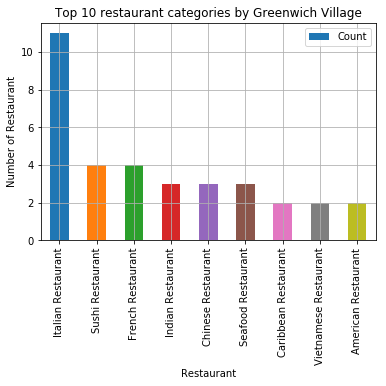

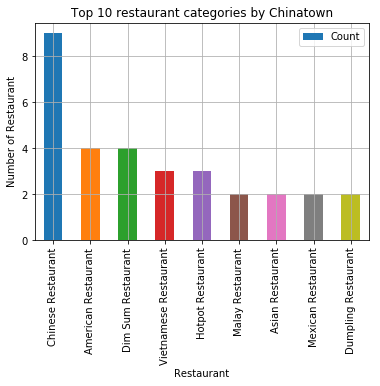

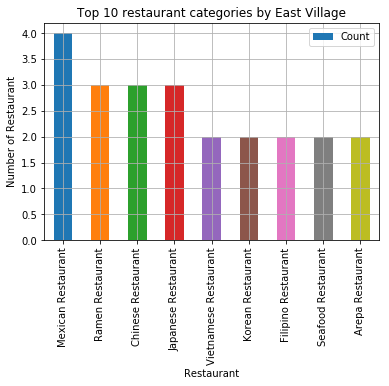

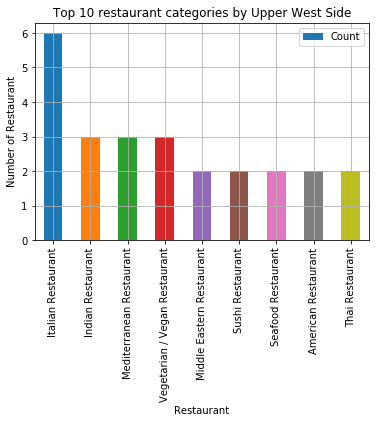

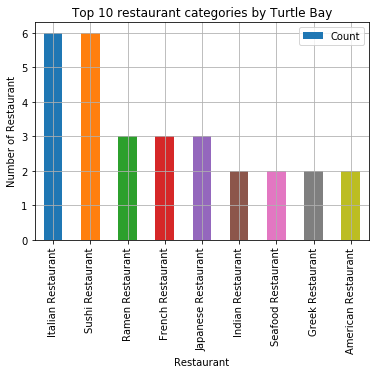

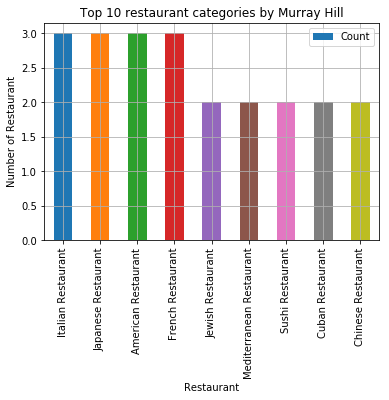

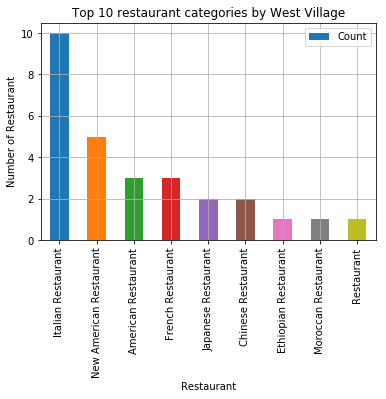

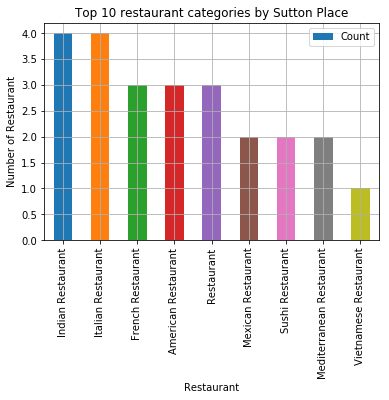

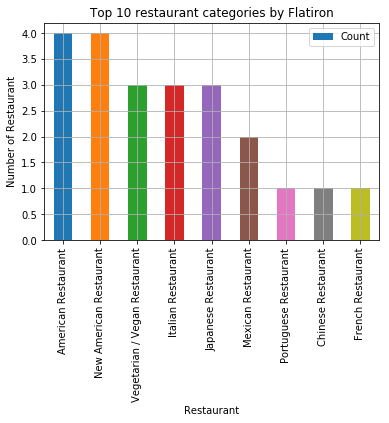

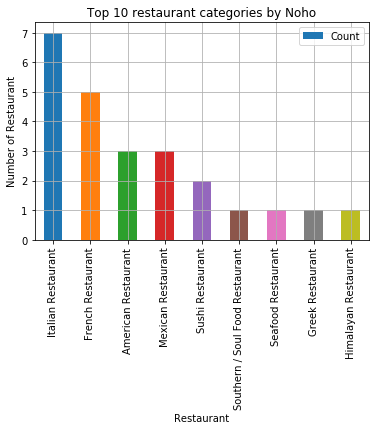

In [19]:
# STEP  2 Plot data
num_top_venues = 10
rest_list = []
cnt_list = []

for i in np.arange(num_top_venues):
    for j in np.arange(num_top_venues):
        rest_list.append(neighborhoods_venues_sorted.iloc[i,j])
        cnt_list.append(neighborhoods_venues_sorted_count.iloc[i,j])

#         print('Neighborhood = ', neighborhoods_venues_sorted.iloc[i,0], 
#                ' | Restaurant =', neighborhoods_venues_sorted.iloc[i,j+1],
#                ' | Count = ', neighborhoods_venues_sorted_count.iloc[i,j+1])
    ShowPlot(rest_list, cnt_list)
    rest_list = []
    cnt_list = []

#print (rest_list)
#print (cnt_list)



### step 3: Analyze the result

From the results set, we are going to define Asian restaurants with different names as for the grouping purpose. The following restaurants will be considered as part of Asian Restaurant Group.

- Sushi Restaurant
- Chinease Restaurant
- Japanese Restaurant
- Korean Restaurant
- Vietnamese
- Dim Sum Restaurant
- Hotpot Restaurant
- Dumpling Restaurant
- Ramen Restaurant
- Filipino Restaurant
- Thai Restaurant

The identification of Asian Restaurant Group is important as this group will be used as a base for the composition of competitors in the neighborhood. Basically, the more Asian restaurants means more competition.                                                                                                                                          

## Results

## Discussion

## Conclusion